In [1]:
import torch
from torch import nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
# Create some data using the linear regression formula y = weight * X + bias
# Create *known* parameters 
# weight = 0.3
# bias = 0.9
weight = 0.3
bias = 0.9

# Create
start = 0
end = 1
step = 0.01

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1).to(device)
y = weight * X + bias

print(f"Number of X samples: {len(X)}")
print(f"Number of y samples: {len(y)}")
print(f"First 10 X & y samples:\nX: {X[:10]}\ny: {y[:10]}")

Number of X samples: 100
Number of y samples: 100
First 10 X & y samples:
X: tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400],
        [0.0500],
        [0.0600],
        [0.0700],
        [0.0800],
        [0.0900]], device='cuda:0')
y: tensor([[0.9000],
        [0.9030],
        [0.9060],
        [0.9090],
        [0.9120],
        [0.9150],
        [0.9180],
        [0.9210],
        [0.9240],
        [0.9270]], device='cuda:0')


In [3]:
# Split data
train_split = int(0.8 * len(X))
X_train = X[:train_split]
y_train = y[:train_split]
X_test = X[train_split:]
y_test = y[train_split:]

In [4]:
# Visualization function
def plot_predictions(train_data=X_train.cpu(),
                     train_labels=y_train.cpu(),
                     test_data=X_test.cpu(),
                     test_labels=y_test.cpu(),
                     predictions=None):
    """
    Plots training data, test data and compares predictions
    """
    # Canvas size
    plt.figure(figsize=(7, 7))

    # plt.scatter(x, y, c)
    # x, y - coordinates
    # c - color
    # s - dot size
    
    # Plot training data in blue
    plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')

    # Plot training data in green
    plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')

    # Are there predictions 
    if predictions is not None:
        # Plot the predictions if they exists
        plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

    # Show the legend
    plt.legend(prop={'size': 14})

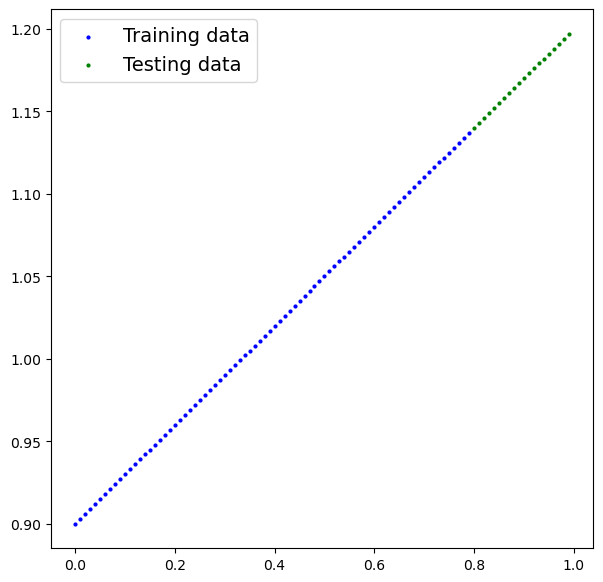

In [5]:
plot_predictions()

In [6]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating model parameters / also called: linear transform, probing layer 
        self.linear_layer = nn.Linear(in_features=1,
                                     out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [7]:
torch.manual_seed(42)
model = LinearRegressionModel()
# Set model to use the target device (GPU)
model.to(device)
# Check the model current device
next(model.parameters()).device

device(type='cuda', index=0)

In [8]:
# Setup loss function
loss_fn = nn.L1Loss()

# Setup our optimizer
optimizer = torch.optim.SGD(params=model.parameters(),
                                 lr=0.01)

In [9]:
# Training loop
# torch.manual_seed(42)

# An epoch is one loop through the data
# epoch is hyperparameter because we've set it ourselves
epochs = 600

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

# Loop through the data
for epoch in range(epochs):
    # Set the model to training mode
    model.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

    # 1. Forward pass
    y_preds = model(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_preds, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Perform back propagation on the loss with respect to the parameters of the model
    loss.backward()

    # 5. Optimizer step - perform gradient descent
    # by default how the optimizer changes will accumulate through the loop, so we have to zero them above in step 3 for the next iteration of the loop
    optimizer.step() 

    
    # Testing
    model.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/batch norm lay layers)
    with torch.inference_mode(): # Turns off gradient tracking
        # 1. Do the forward pass
        test_pred = model(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)
        
    if epoch % 20 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")        

Epoch: 0 | Loss: 0.1275613158941269 | Test loss: 0.33650314807891846
Epoch: 20 | Loss: 0.08187223970890045 | Test loss: 0.21840262413024902
Epoch: 40 | Loss: 0.07207288593053818 | Test loss: 0.17458660900592804
Epoch: 60 | Loss: 0.06507988274097443 | Test loss: 0.15310420095920563
Epoch: 80 | Loss: 0.05822876840829849 | Test loss: 0.1367770880460739
Epoch: 100 | Loss: 0.05137667804956436 | Test loss: 0.12079393863677979
Epoch: 120 | Loss: 0.04452557489275932 | Test loss: 0.10446684807538986
Epoch: 140 | Loss: 0.0376744270324707 | Test loss: 0.08813951909542084
Epoch: 160 | Loss: 0.03082224726676941 | Test loss: 0.0721558928489685
Epoch: 180 | Loss: 0.02397105097770691 | Test loss: 0.055828340351581573
Epoch: 200 | Loss: 0.017119847238063812 | Test loss: 0.03950077295303345
Epoch: 220 | Loss: 0.010267681442201138 | Test loss: 0.02351718582212925
Epoch: 240 | Loss: 0.003416901919990778 | Test loss: 0.007191836833953857
Epoch: 260 | Loss: 0.007878492586314678 | Test loss: 0.00706423539668

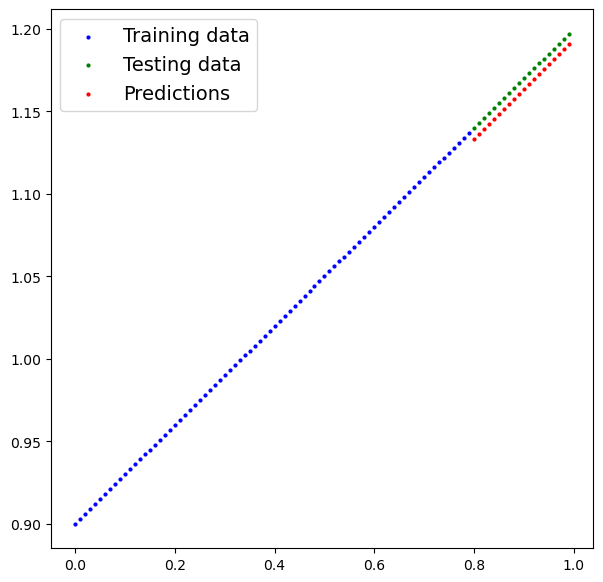

In [10]:
# Visualize
model.eval()

with torch.inference_mode():
    y_pred = model(X_test)


plot_predictions(train_data=X_train.cpu(),
                     train_labels=y_train.cpu(),
                     test_data=X_test.cpu(),
                     test_labels=y_test.cpu(),
                     predictions=y_pred.cpu())



In [11]:
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.3028]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8910], device='cuda:0'))])

In [12]:
weight, bias

(0.3, 0.9)